## Complex Model

In [4]:
%%writefile complex_model.py
import torch
import torch.nn as nn

class ComplEx(nn.Module):
    """
    ComplEx embeddings (real+imag). OOM-safe evaluation via GEMM.
    """

    def __init__(self, num_nodes: int, num_relations: int, dim: int = 200, dropout: float = 0.0):
        super().__init__()
        self.num_nodes = num_nodes
        self.num_relations = num_relations
        self.dim = dim

        self.ent_re = nn.Embedding(num_nodes, dim)
        self.ent_im = nn.Embedding(num_nodes, dim)
        self.rel_re = nn.Embedding(num_relations, dim)
        self.rel_im = nn.Embedding(num_relations, dim)

        self.dropout = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        for emb in (self.ent_re, self.ent_im, self.rel_re, self.rel_im):
            nn.init.xavier_uniform_(emb.weight)

    def forward(self, h, r, t):
        hr = self.ent_re(h)
        hi = self.ent_im(h)
        rr = self.rel_re(r)
        ri = self.rel_im(r)
        tr = self.ent_re(t)
        ti = self.ent_im(t)
        return (hr * rr * tr + hi * rr * ti + hr * ri * ti - hi * ri * tr).sum(dim=-1)

    @torch.no_grad()
    def score_all_tails(self, h, r, chunk_size: int = 20000, query_batch_size: int = 128):
        """
        Memory-safe scoring of (h,r,?) against all entities using GEMM:
          a = hr*rr - hi*ri
          b = hr*ri + hi*rr
          score = a @ t_re.T + b @ t_im.T
        Returns: [B, num_nodes]
        """
        device = self.ent_re.weight.device
        h = h.to(device)
        r = r.to(device)

        ent_re = self.ent_re.weight  # [N,D]
        ent_im = self.ent_im.weight  # [N,D]

        out_scores = []
        for qs in range(0, h.size(0), query_batch_size):
            qe = min(qs + query_batch_size, h.size(0))
            hb = h[qs:qe]
            rb = r[qs:qe]

            hr = self.ent_re(hb)
            hi = self.ent_im(hb)
            rr = self.rel_re(rb)
            ri = self.rel_im(rb)

            a = hr * rr - hi * ri
            b = hr * ri + hi * rr

            chunks = []
            for start in range(0, self.num_nodes, chunk_size):
                end = min(start + chunk_size, self.num_nodes)
                tr = ent_re[start:end]
                ti = ent_im[start:end]
                chunks.append(a @ tr.T + b @ ti.T)  # [B,C]
            out_scores.append(torch.cat(chunks, dim=1))
        return torch.cat(out_scores, dim=0)


Writing complex_model.py


In [5]:
%%writefile train_complex.py
import os, time, math, json, random
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

from complex_model import ComplEx

# -------------------------------
# PATHS
# -------------------------------
GRAPH_DATA = "/kaggle/input/graph-data-sets/graph_data.pt"  # adjust if needed
SAVE_DIR   = "/kaggle/working/complex_output"
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# SAFE / SCALABLE DEFAULTS
# -------------------------------
EMB_DIM = 512
DROPOUT = 0.1
LR = 1e-3
WEIGHT_DECAY = 0.0
EPOCHS = 5

BATCH_EDGES = 4096
NEGATIVE_RATIO = 1
GRAD_CLIP = 1.0

# Filtered ranking eval (subset + chunking)
VAL_MAX_TRIPLES = 400
EVAL_CHUNK_SIZE = 20000
EVAL_QUERY_BATCH = 128

# Save pos/neg score arrays for final graphs (ROC/Precision@K/hist)
SCORES_MAX_TRIPLES = 2000
SCORES_NEG_PER_POS = 50

SEED = 42

# -------------------------------
def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_graph(graph_path: str):
    data = torch.load(graph_path, map_location="cpu")
    edge_index = data["edge_index"].long()
    edge_type  = data["edge_type"].long()
    train_idx  = data["train_idx"].long()
    val_idx    = data["val_idx"].long()
    test_idx   = data["test_idx"].long()
    num_nodes  = int(data["num_nodes"])
    num_rels   = int(data["num_relations"])
    return edge_index, edge_type, train_idx, val_idx, test_idx, num_nodes, num_rels

def make_batch(edge_index, edge_type, idx):
    h = edge_index[0, idx]
    t = edge_index[1, idx]
    r = edge_type[idx]
    return h, r, t

def build_true_tail_dict(edge_index, edge_type):
    true_tails = {}
    h_all = edge_index[0].tolist()
    t_all = edge_index[1].tolist()
    r_all = edge_type.tolist()
    for h, r, t in zip(h_all, r_all, t_all):
        key = (h, r)
        if key not in true_tails:
            true_tails[key] = set()
        true_tails[key].add(t)
    return true_tails

@torch.no_grad()
def eval_filtered_mrr_hits(model, edge_index, edge_type, eval_idx, num_nodes, true_tails,
                           max_triples=400, chunk_size=20000, query_batch=128, device="cuda"):
    model.eval()
    if eval_idx.numel() > max_triples:
        eval_idx = eval_idx[torch.randperm(eval_idx.numel())[:max_triples]]

    h, r, t = make_batch(edge_index, edge_type, eval_idx)
    h = h.to(device); r = r.to(device); t = t.to(device)

    scores = model.score_all_tails(h, r, chunk_size=chunk_size, query_batch_size=query_batch)
    scores = scores.clone()

    for i in range(h.size(0)):
        key = (int(h[i].item()), int(r[i].item()))
        tails = true_tails.get(key, None)
        if not tails:
            continue
        tgt = int(t[i].item())
        for tt in tails:
            if tt != tgt:
                scores[i, tt] = -1e9

    target_scores = scores.gather(1, t.view(-1, 1)).squeeze(1)
    ranks = (scores > target_scores.unsqueeze(1)).sum(dim=1) + 1

    mrr = (1.0 / ranks.float()).mean().item()
    h1 = (ranks <= 1).float().mean().item()
    h10 = (ranks <= 10).float().mean().item()
    return mrr, h1, h10

@torch.no_grad()
def collect_pos_neg_scores(model, edge_index, edge_type, eval_idx, num_nodes,
                           max_triples=2000, neg_per_pos=50, device="cuda"):
    model.eval()
    if eval_idx.numel() > max_triples:
        eval_idx = eval_idx[torch.randperm(eval_idx.numel())[:max_triples]]

    h = edge_index[0, eval_idx].to(device)
    t = edge_index[1, eval_idx].to(device)
    r = edge_type[eval_idx].to(device)

    pos_scores = model(h, r, t)  # (N,)
    neg_t = torch.randint(0, num_nodes, (h.size(0), neg_per_pos), device=device)  # (N,K)

    h_rep = h.repeat_interleave(neg_per_pos)
    r_rep = r.repeat_interleave(neg_per_pos)
    neg_scores = model(h_rep, r_rep, neg_t.view(-1)).view(h.size(0), neg_per_pos)  # (N,K)

    return pos_scores.detach().cpu().numpy(), neg_scores.detach().cpu().numpy()

# -------------------------------
def main():
    seed_all(SEED)

    print("Loading:", GRAPH_DATA)
    edge_index, edge_type, train_idx, val_idx, test_idx, num_nodes, num_rels = load_graph(GRAPH_DATA)
    print(f"Loaded graph_data.pt: nodes={num_nodes}, rels={num_rels}, edges={edge_type.numel()}")

    print("Building filtered-eval map (CPU)...")
    true_tails = build_true_tail_dict(edge_index, edge_type)
    print(f"Done: {len(true_tails)} (head,relation) keys")

    model = ComplEx(num_nodes=num_nodes, num_relations=num_rels, dim=EMB_DIM, dropout=DROPOUT).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scaler = GradScaler("cuda", enabled=(DEVICE == "cuda"))

    history = {"epoch": [], "loss": [], "val_mrr": [], "val_h1": [], "val_h10": []}

    best_val_mrr = -1.0
    best_ckpt_path  = os.path.join(SAVE_DIR, "best_complex.pt")
    final_ckpt_path = os.path.join(SAVE_DIR, "final_complex.pt")

    with open(os.path.join(SAVE_DIR, "run_config.json"), "w") as f:
        json.dump({
            "GRAPH_DATA": GRAPH_DATA,
            "EMB_DIM": EMB_DIM,
            "DROPOUT": DROPOUT,
            "LR": LR,
            "EPOCHS": EPOCHS,
            "BATCH_EDGES": BATCH_EDGES,
            "NEGATIVE_RATIO": NEGATIVE_RATIO,
            "VAL_MAX_TRIPLES": VAL_MAX_TRIPLES,
            "EVAL_CHUNK_SIZE": EVAL_CHUNK_SIZE,
            "EVAL_QUERY_BATCH": EVAL_QUERY_BATCH,
            "SCORES_MAX_TRIPLES": SCORES_MAX_TRIPLES,
            "SCORES_NEG_PER_POS": SCORES_NEG_PER_POS,
            "SEED": SEED
        }, f, indent=2)

    train_edges = train_idx.clone()

    for ep in range(1, EPOCHS + 1):
        model.train()
        train_edges = train_edges[torch.randperm(train_edges.numel())]

        num_batches = math.ceil(train_edges.numel() / BATCH_EDGES)
        total_loss = 0.0
        t0 = time.time()

        for b in range(num_batches):
            start = b * BATCH_EDGES
            end = min((b + 1) * BATCH_EDGES, train_edges.numel())
            batch_idx = train_edges[start:end]

            h, r, t = make_batch(edge_index, edge_type, batch_idx)
            h = h.to(DEVICE); r = r.to(DEVICE); t = t.to(DEVICE)

            neg_t = torch.randint(0, num_nodes, (h.size(0) * NEGATIVE_RATIO,), device=DEVICE)
            h_rep = h.repeat_interleave(NEGATIVE_RATIO)
            r_rep = r.repeat_interleave(NEGATIVE_RATIO)

            opt.zero_grad(set_to_none=True)
            with autocast("cuda", enabled=(DEVICE == "cuda")):
                pos_score = model(h, r, t)
                neg_score = model(h_rep, r_rep, neg_t)
                loss = F.softplus(-pos_score).mean() + F.softplus(neg_score).mean()

            scaler.scale(loss).backward()
            if GRAD_CLIP is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(opt)
            scaler.update()

            total_loss += loss.item()
            if (b + 1) % 100 == 0 or (b + 1) == num_batches:
                print(f"Epoch {ep} | Batch {b+1}/{num_batches} | Loss {total_loss/(b+1):.4f}")

        train_loss = total_loss / max(1, num_batches)

        val_mrr, val_h1, val_h10 = eval_filtered_mrr_hits(
            model, edge_index, edge_type, val_idx, num_nodes, true_tails,
            max_triples=VAL_MAX_TRIPLES,
            chunk_size=EVAL_CHUNK_SIZE,
            query_batch=EVAL_QUERY_BATCH,
            device=DEVICE
        )

        print(
            f"Epoch {ep} done in {(time.time()-t0)/60:.2f} min | "
            f"train_loss={train_loss:.4f} | Filtered val MRR={val_mrr:.4f} H@1={val_h1:.4f} H@10={val_h10:.4f}"
        )

        history["epoch"].append(ep)
        history["loss"].append(train_loss)
        history["val_mrr"].append(val_mrr)
        history["val_h1"].append(val_h1)
        history["val_h10"].append(val_h10)

        # Save only BEST checkpoint
        if val_mrr > best_val_mrr:
            best_val_mrr = val_mrr
            torch.save({
                "model_state": model.state_dict(),
                "num_nodes": num_nodes,
                "num_relations": num_rels,
                "emb_dim": EMB_DIM,
                "best_val_mrr": best_val_mrr,
                "epoch": ep
            }, best_ckpt_path)
            print(f"Saved BEST checkpoint: {best_ckpt_path} (MRR={best_val_mrr:.4f})")

    # ✅ Save FINAL model checkpoint (end of training)
    torch.save({
        "model_state": model.state_dict(),
        "num_nodes": num_nodes,
        "num_relations": num_rels,
        "emb_dim": EMB_DIM,
        "epoch": EPOCHS,
        "note": "Final epoch model"
    }, final_ckpt_path)
    print("Saved FINAL checkpoint:", final_ckpt_path)

    # Save history
    np.save(os.path.join(SAVE_DIR, "training_history.npy"), history)
    print("Saved training history:", os.path.join(SAVE_DIR, "training_history.npy"))

    # Save pos/neg score arrays ONCE (after training)
    print("Collecting validation pos/neg scores for FINAL graphs...")
    pos_scores, neg_scores = collect_pos_neg_scores(
        model, edge_index, edge_type, val_idx, num_nodes,
        max_triples=SCORES_MAX_TRIPLES,
        neg_per_pos=SCORES_NEG_PER_POS,
        device=DEVICE
    )
    np.save(os.path.join(SAVE_DIR, "pos_scores.npy"), pos_scores)
    np.save(os.path.join(SAVE_DIR, "neg_scores.npy"), neg_scores)
    print("Saved:", os.path.join(SAVE_DIR, "pos_scores.npy"))
    print("Saved:", os.path.join(SAVE_DIR, "neg_scores.npy"))

if __name__ == "__main__":
    main()


Writing train_complex.py


In [6]:
!python train_complex.py

Loading: /kaggle/input/graph-data-sets/graph_data.pt
Loaded graph_data.pt: nodes=423619, rels=266, edges=4584754
Building filtered-eval map (CPU)...
Done: 1448872 (head,relation) keys
Epoch 1 | Batch 100/896 | Loss 1.3863
Epoch 1 | Batch 200/896 | Loss 1.3848
Epoch 1 | Batch 300/896 | Loss 1.3640
Epoch 1 | Batch 400/896 | Loss 1.3139
Epoch 1 | Batch 500/896 | Loss 1.2583
Epoch 1 | Batch 600/896 | Loss 1.2080
Epoch 1 | Batch 700/896 | Loss 1.1646
Epoch 1 | Batch 800/896 | Loss 1.1272
Epoch 1 | Batch 896/896 | Loss 1.0961
Epoch 1 done in 1.99 min | train_loss=1.0961 | Filtered val MRR=0.1673 H@1=0.1325 H@10=0.2300
Saved BEST checkpoint: /kaggle/working/complex_output/best_complex.pt (MRR=0.1673)
Epoch 2 | Batch 100/896 | Loss 0.7842
Epoch 2 | Batch 200/896 | Loss 0.7764
Epoch 2 | Batch 300/896 | Loss 0.7681
Epoch 2 | Batch 400/896 | Loss 0.7592
Epoch 2 | Batch 500/896 | Loss 0.7492
Epoch 2 | Batch 600/896 | Loss 0.7380
Epoch 2 | Batch 700/896 | Loss 0.7255
Epoch 2 | Batch 800/896 | Loss 

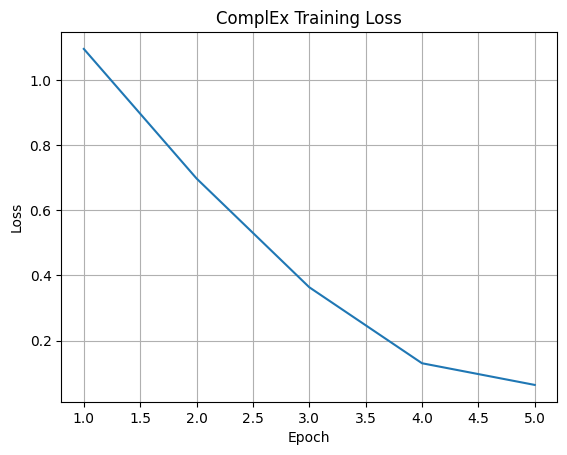

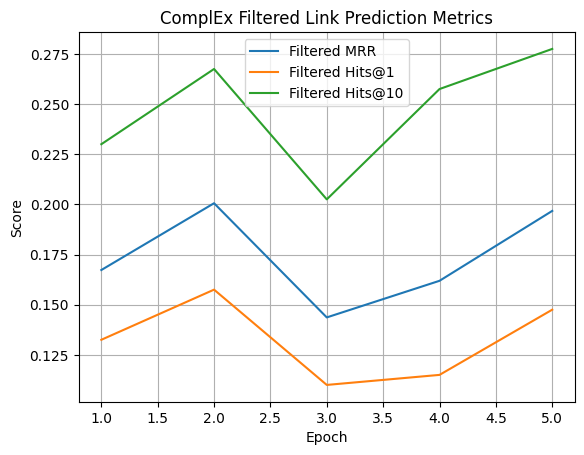

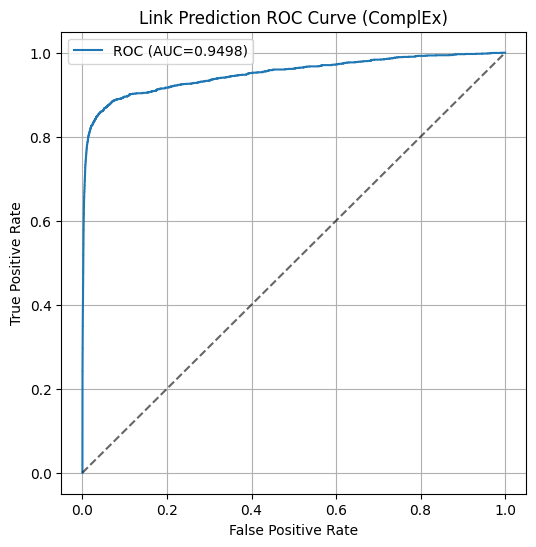

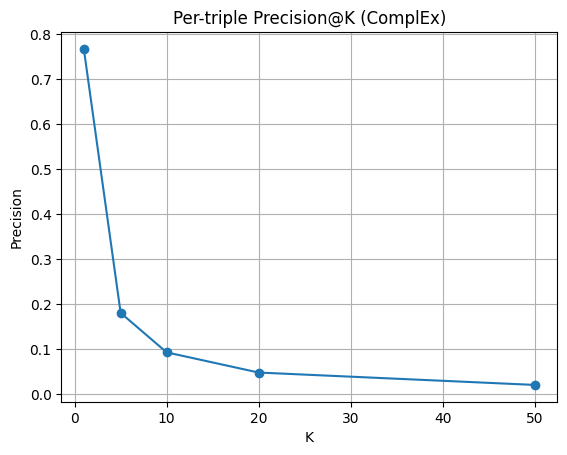

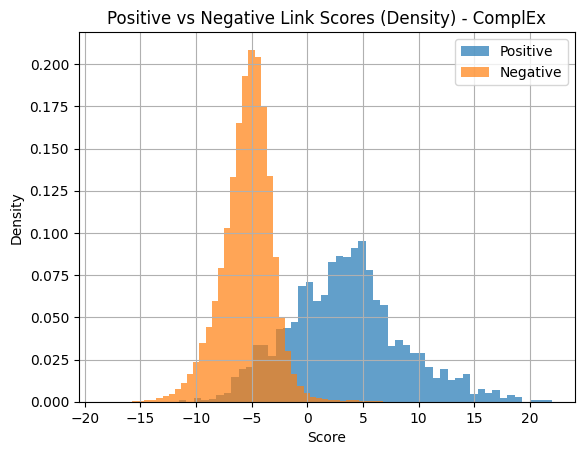

✅ All graphs saved in: /kaggle/working/complex_output


In [7]:
# plots_complex.py
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Same output folder as train_complex.py
SAVE_DIR = "/kaggle/working/complex_output"

def plot_training_curves(history, out_dir):
    epochs = history["epoch"]
    loss = history["loss"]
    mrr = history["val_mrr"]
    h1  = history["val_h1"]
    h10 = history["val_h10"]

    # Loss curve
    plt.figure()
    plt.plot(epochs, loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("ComplEx Training Loss")
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "training_loss.png"))
    plt.show()

    # Ranking metrics curve
    plt.figure()
    plt.plot(epochs, mrr, label="Filtered MRR")
    plt.plot(epochs, h1, label="Filtered Hits@1")
    plt.plot(epochs, h10, label="Filtered Hits@10")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("ComplEx Filtered Link Prediction Metrics")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "link_prediction_metrics.png"))
    plt.show()

def plot_roc_precision_hist(pos, neg, out_dir):
    # pos: (N,)
    # neg: (N,K)
    pos = pos.reshape(-1)
    neg = neg.reshape(-1)

    labels = np.concatenate([np.ones_like(pos), np.zeros_like(neg)])
    scores = np.concatenate([pos, neg])

    # ROC
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
    plt.plot([0,1], [0,1], "k--", alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Link Prediction ROC Curve (ComplEx)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "roc_curve_complex.png"))
    plt.show()

    # Precision@K per-triple (same idea as your R-GCN plotting)
    neg_matrix = np.load(os.path.join(out_dir, "neg_scores.npy"))  # (N,K)
    pos_vec = np.load(os.path.join(out_dir, "pos_scores.npy"))     # (N,)
    N, Kneg = neg_matrix.shape

    def precision_at_k_per_triple(pos_scores, neg_scores, K):
        K = min(K, neg_scores.shape[1] + 1)
        precisions = []
        for i in range(len(pos_scores)):
            scores_i = np.concatenate([[pos_scores[i]], neg_scores[i]])
            labels_i = np.concatenate([[1], np.zeros(neg_scores.shape[1])])
            idx = np.argsort(scores_i)[::-1][:K]
            precisions.append(labels_i[idx].mean())
        return float(np.mean(precisions))

    Ks = [1, 5, 10, 20, min(50, Kneg)]
    precisions = [precision_at_k_per_triple(pos_vec, neg_matrix, k) for k in Ks]

    plt.figure()
    plt.plot(Ks, precisions, marker="o")
    plt.xlabel("K")
    plt.ylabel("Precision")
    plt.title("Per-triple Precision@K (ComplEx)")
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "precision_at_k_per_triple.png"))
    plt.show()

    # Score distribution (density)
    plt.figure()
    plt.hist(pos, bins=50, alpha=0.7, label="Positive", density=True)
    plt.hist(neg, bins=50, alpha=0.7, label="Negative", density=True)
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.title("Positive vs Negative Link Scores (Density) - ComplEx")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "score_distribution_density.png"))
    plt.show()

def main():
    hist_path = os.path.join(SAVE_DIR, "training_history.npy")
    pos_path  = os.path.join(SAVE_DIR, "pos_scores.npy")
    neg_path  = os.path.join(SAVE_DIR, "neg_scores.npy")

    if not os.path.exists(hist_path):
        print("❌ Missing:", hist_path)
        return
    if not os.path.exists(pos_path) or not os.path.exists(neg_path):
        print("❌ Missing pos/neg score files. Run train_complex.py first.")
        return

    history = np.load(hist_path, allow_pickle=True).item()
    pos = np.load(pos_path)
    neg = np.load(neg_path)

    plot_training_curves(history, SAVE_DIR)
    plot_roc_precision_hist(pos, neg, SAVE_DIR)

    print("✅ All graphs saved in:", SAVE_DIR)

if __name__ == "__main__":
    main()


# Hybrid RoBERTa + R-GCN

In [8]:
%%writefile model_components_hybrid.py
import random
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F


# GAP-1 + TEXT: Dynamic-capacity embedding + RoBERTa fusion
class DynamicTextEmbedder(nn.Module):
    """
    - High-degree nodes: larger learnable embedding -> projected to common dim
    - Low-degree nodes: smaller learnable embedding -> projected to common dim
    - RoBERTa text embedding (precomputed): projected to common dim
    - Fusion: gated (recommended), sum, or concat
    """

    def __init__(
        self,
        num_nodes: int,
        high_nodes: torch.Tensor,
        low_nodes: torch.Tensor,
        emb_dim_high: int,
        emb_dim_low: int,
        emb_dim_common: int,
        text_dim: int = 768,
        fusion: str = "gated",
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.emb_dim_common = emb_dim_common
        self.fusion = fusion

        # ---- store membership via vector maps (fast/scalable) ----
        map_high = torch.full((num_nodes,), -1, dtype=torch.long)
        map_low  = torch.full((num_nodes,), -1, dtype=torch.long)

        high_nodes = high_nodes.long().cpu()
        low_nodes  = low_nodes.long().cpu()

        map_high[high_nodes] = torch.arange(high_nodes.numel(), dtype=torch.long)
        map_low[low_nodes]   = torch.arange(low_nodes.numel(), dtype=torch.long)

        self.register_buffer("map_high", map_high)
        self.register_buffer("map_low", map_low)

        # ---- learnable embeddings (dynamic capacity) ----
        self.emb_high = nn.Embedding(high_nodes.numel(), emb_dim_high)
        self.emb_low  = nn.Embedding(low_nodes.numel(), emb_dim_low)

        self.proj_high = nn.Linear(emb_dim_high, emb_dim_common)
        self.proj_low  = nn.Linear(emb_dim_low,  emb_dim_common)

        # ---- text projection ----
        self.text_proj = nn.Linear(text_dim, emb_dim_common)

        # ---- fusion ----
        if fusion == "gated":
            self.gate = nn.Sequential(
                nn.Linear(emb_dim_common * 2, emb_dim_common),
                nn.Sigmoid()
            )
        elif fusion == "concat":
            self.fuse = nn.Linear(emb_dim_common * 2, emb_dim_common)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.emb_high.weight)
        nn.init.xavier_uniform_(self.emb_low.weight)
        nn.init.xavier_uniform_(self.proj_high.weight); nn.init.zeros_(self.proj_high.bias)
        nn.init.xavier_uniform_(self.proj_low.weight);  nn.init.zeros_(self.proj_low.bias)
        nn.init.xavier_uniform_(self.text_proj.weight); nn.init.zeros_(self.text_proj.bias)
        if self.fusion == "concat":
            nn.init.xavier_uniform_(self.fuse.weight); nn.init.zeros_(self.fuse.bias)

    def forward(self, node_ids: torch.Tensor, text_emb_cpu: torch.Tensor) -> torch.Tensor:
        """
        node_ids: [B] (GPU)
        text_emb_cpu: [num_nodes, text_dim] (CPU recommended)
        returns: [B, emb_dim_common] float32
        """
        device = node_ids.device
        node_ids_cpu = node_ids.detach().cpu()

        hi = self.map_high[node_ids_cpu]  # [B] on CPU
        lo = self.map_low[node_ids_cpu]   # [B] on CPU

        # keep dyn as float32; cast projected values to match
        dyn = torch.zeros(node_ids.size(0), self.emb_dim_common, device=device, dtype=torch.float32)

        hi_mask = (hi >= 0)
        if hi_mask.any():
            hi_idx = hi[hi_mask].to(device)
            dyn_hi = self.proj_high(self.emb_high(hi_idx)).to(dtype=dyn.dtype)  # ✅ fixed
            dyn[hi_mask.to(device)] = dyn_hi

        lo_mask = (lo >= 0)
        if lo_mask.any():
            lo_idx = lo[lo_mask].to(device)
            dyn_lo = self.proj_low(self.emb_low(lo_idx)).to(dtype=dyn.dtype)    # ✅ fixed
            dyn[lo_mask.to(device)] = dyn_lo

        # text gather (CPU -> GPU for just this batch)
        te = text_emb_cpu[node_ids_cpu].to(device=device, dtype=torch.float32)
        txt = self.text_proj(te).to(dtype=dyn.dtype)

        # fusion
        if self.fusion == "sum":
            out = dyn + txt
        elif self.fusion == "concat":
            out = self.fuse(torch.cat([dyn, txt], dim=-1)).to(dtype=dyn.dtype)
        else:  # gated
            g = self.gate(torch.cat([dyn, txt], dim=-1)).to(dtype=dyn.dtype)
            out = g * dyn + (1.0 - g) * txt

        return out


# Memory-safe R-GCN Layer=====================================
class RGCNLayer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, num_relations: int):
        super().__init__()
        self.num_relations = num_relations
        self.W_r = nn.Parameter(torch.empty(num_relations, in_dim, out_dim))
        self.W_0 = nn.Linear(in_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_r)
        nn.init.xavier_uniform_(self.W_0.weight)
        nn.init.zeros_(self.W_0.bias)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_type: torch.Tensor, num_nodes_local: int):
        src = edge_index[0]
        dst = edge_index[1]

        out = torch.zeros(num_nodes_local, self.W_0.out_features, device=x.device, dtype=x.dtype)

        deg = torch.zeros(num_nodes_local, device=x.device, dtype=x.dtype)
        deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

        for r in range(self.num_relations):
            m = (edge_type == r)
            if m.sum() == 0:
                continue
            s = src[m]
            d = dst[m]
            msg = x[s] @ self.W_r[r]
            msg = msg / deg[d].clamp_min(1).unsqueeze(1)
            out.index_add_(0, d, msg)

        return out + self.W_0(x)


# Hybrid model: DynamicTextEmbedder + R-GCN + DistMult scoring
class HybridRoBERTaRGCN(nn.Module):
    def __init__(
        self,
        num_nodes: int,
        num_relations: int,
        high_nodes: torch.Tensor,
        low_nodes: torch.Tensor,
        emb_dim_high: int,
        emb_dim_low: int,
        emb_dim_common: int,
        hidden_dim: int,
        num_layers: int,
        dropout: float,
        text_dim: int = 768,
        fusion: str = "gated",
    ):
        super().__init__()
        self.num_relations = num_relations
        self.emb_dim_common = emb_dim_common

        self.embedder = DynamicTextEmbedder(
            num_nodes=num_nodes,
            high_nodes=high_nodes,
            low_nodes=low_nodes,
            emb_dim_high=emb_dim_high,
            emb_dim_low=emb_dim_low,
            emb_dim_common=emb_dim_common,
            text_dim=text_dim,
            fusion=fusion,
        )

        layers = []
        in_dim = emb_dim_common
        for i in range(num_layers):
            out_dim = hidden_dim if i < num_layers - 1 else emb_dim_common
            layers.append(RGCNLayer(in_dim, out_dim, num_relations))
            in_dim = out_dim
        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout)

        self.rel_embed = nn.Embedding(num_relations, emb_dim_common)
        nn.init.xavier_uniform_(self.rel_embed.weight)

    def forward(self, local_nodes: torch.Tensor, edge_index_local: torch.Tensor, edge_type_local: torch.Tensor, text_emb_cpu: torch.Tensor):
        x = self.embedder(local_nodes, text_emb_cpu)
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index_local, edge_type_local, local_nodes.numel())
            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return x

    def score(self, h_global: torch.Tensor, r: torch.Tensor, t_global: torch.Tensor, local_nodes: torch.Tensor, local_emb: torch.Tensor):
        # global->local map
        lut = {int(g): i for i, g in enumerate(local_nodes.tolist())}
        device = local_nodes.device
        h_loc = torch.tensor([lut[int(i)] for i in h_global.tolist()], device=device)
        t_loc = torch.tensor([lut[int(i)] for i in t_global.tolist()], device=device)

        h = local_emb[h_loc]
        t = local_emb[t_loc]
        rv = self.rel_embed(r)
        return (h * rv * t).sum(dim=-1)



# Degree split (GAP-1)
def degree_split(num_nodes: int, edge_index: torch.Tensor, pct: float):
    src = edge_index[0].detach().cpu()
    dst = edge_index[1].detach().cpu()
    deg = torch.zeros(num_nodes, dtype=torch.long)
    deg.index_add_(0, src, torch.ones_like(src, dtype=torch.long))
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=torch.long))

    thresh = int(torch.quantile(deg.float(), pct).item())
    high = (deg >= thresh).nonzero(as_tuple=False).view(-1)
    low  = (deg < thresh).nonzero(as_tuple=False).view(-1)
    return high, low


# GAP-2: Subgraph sampling from node-centric adjacency
# node_adj[u] = [(rel, v), ...]
def sample_subgraph(
    seeds: torch.Tensor,
    num_layers: int,
    num_neighbors: int,
    node_adj: Dict[int, List[Tuple[int, int]]],
    max_edges: int,
):
    frontier = set(int(s) for s in seeds.tolist())
    nodes = set(frontier)

    for _ in range(num_layers):
        new_frontier = set()
        for u in list(frontier):
            if u not in node_adj:
                continue
            nbrs = node_adj[u]
            chosen = nbrs if len(nbrs) <= num_neighbors else random.sample(nbrs, num_neighbors)
            for r, v in chosen:
                if v not in nodes:
                    nodes.add(v)
                    new_frontier.add(v)
        frontier = new_frontier
        if len(nodes) * max(1, num_neighbors) * max(1, num_layers) > 2 * max_edges:
            break

    local_nodes_list = sorted(nodes)
    lut = {g: i for i, g in enumerate(local_nodes_list)}

    ls, ld, lr = [], [], []
    edge_count = 0
    for u in local_nodes_list:
        if u not in node_adj:
            continue
        u_loc = lut[u]
        for r, v in node_adj[u]:
            if v in nodes:
                ls.append(u_loc)
                ld.append(lut[v])
                lr.append(int(r))
                edge_count += 1
                if edge_count >= max_edges:
                    break
        if edge_count >= max_edges:
            break

    device = seeds.device
    local_nodes = torch.tensor(local_nodes_list, dtype=torch.long, device=device)

    if edge_count > 0:
        edge_index_local = torch.tensor([ls, ld], dtype=torch.long, device=device)
        edge_type_local = torch.tensor(lr, dtype=torch.long, device=device)
    else:
        edge_index_local = torch.empty((2, 0), dtype=torch.long, device=device)
        edge_type_local = torch.empty((0,), dtype=torch.long, device=device)

    return local_nodes, edge_index_local, edge_type_local


def sample_pos_neg(edge_index: torch.Tensor, edge_type: torch.Tensor, idx: torch.Tensor, num_nodes: int, negative_ratio: int):
    pos = edge_index[:, idx]
    pos_r = edge_type[idx]
    B = pos.size(1)

    neg_t = torch.randint(0, num_nodes, (B * negative_ratio,), device=edge_index.device)
    neg_h = pos[0].repeat(negative_ratio)
    neg_r = pos_r.repeat(negative_ratio)
    return pos[0], pos_r, pos[1], neg_h, neg_r, neg_t


Writing model_components_hybrid.py


In [9]:
%%writefile train_hybrid_roberta_rgcn.py
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from contextlib import nullcontext

from model_components_hybrid import (
    HybridRoBERTaRGCN,
    degree_split,
    sample_pos_neg,
    sample_subgraph,
)

# -------------------------------
# Kaggle PATHS (your provided)
# -------------------------------
TEXT_EMB_PATH = "/kaggle/input/robert-node/node_text_emb.pt"
NODE_ADJ_PATH = "/kaggle/input/robert-node/node_adj.pt"
GRAPH_DATA    = "/kaggle/input/graph-data-sets/graph_data.pt"

SAVE_DIR = "/kaggle/working/hybrid_roberta_rgcn_out"
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# SAFE P100 SETTINGS
# -------------------------------
EMB_DIM_HIGH   = 512
EMB_DIM_LOW    = 128
EMB_DIM_COMMON = 256

HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT    = 0.2
FUSION     = "gated"

NUM_NEIGHBORS = 5
HIGH_DEG_PCT  = 0.80

MAX_EDGES  = 300_000
BATCH_SIZE = 2048
EPOCHS     = 5
NEGATIVE_RATIO = 1

LR = 1e-3

# Validation/plots (sampled)
VAL_TRIPLES_FOR_METRICS   = 400
SCORES_TRIPLES_FOR_PLOTS  = 800
SCORES_NEG_PER_POS        = 50


@torch.no_grad()
def eval_sampled_local_ranking(model, edge_index, edge_type, val_idx, node_adj, text_emb_cpu, num_rel, max_triples):
    model.eval()

    if val_idx.numel() > max_triples:
        val_idx = val_idx[torch.randperm(val_idx.numel(), device=val_idx.device)[:max_triples]]

    rr = 0.0
    h1 = 0
    h10 = 0
    total = 0

    for j in range(val_idx.numel()):
        i = val_idx[j]
        h = int(edge_index[0, i].item())
        t = int(edge_index[1, i].item())
        r = int(edge_type[i].item())

        seeds = torch.tensor([h, t], device=DEVICE)
        local_nodes, eidx, etype = sample_subgraph(
            seeds=seeds,
            num_layers=NUM_LAYERS,
            num_neighbors=NUM_NEIGHBORS,
            node_adj=node_adj,
            max_edges=MAX_EDGES
        )

        if local_nodes.numel() < 2:
            continue

        local_emb = model(local_nodes, eidx, etype, text_emb_cpu)

        h_rep = torch.full((local_nodes.numel(),), h, dtype=torch.long, device=DEVICE)
        r_rep = torch.full((local_nodes.numel(),), r, dtype=torch.long, device=DEVICE)

        scores = model.score(h_rep, r_rep, local_nodes, local_nodes, local_emb)

        true_pos = (local_nodes == t).nonzero(as_tuple=True)[0]
        if true_pos.numel() == 0:
            continue
        true_pos = true_pos.item()

        rank = (scores > scores[true_pos]).sum().item() + 1
        rr += 1.0 / rank
        h1 += int(rank <= 1)
        h10 += int(rank <= 10)
        total += 1

    if total == 0:
        return 0.0, 0.0, 0.0

    return rr / total, h1 / total, h10 / total


@torch.no_grad()
def collect_pos_neg_scores_for_plots(model, edge_index, edge_type, val_idx, node_adj, text_emb_cpu):
    model.eval()

    if val_idx.numel() > SCORES_TRIPLES_FOR_PLOTS:
        val_idx = val_idx[torch.randperm(val_idx.numel(), device=val_idx.device)[:SCORES_TRIPLES_FOR_PLOTS]]

    pos_scores = []
    neg_scores = []

    for j in range(val_idx.numel()):
        i = val_idx[j]
        h = int(edge_index[0, i].item())
        t = int(edge_index[1, i].item())
        r = int(edge_type[i].item())

        seeds = torch.tensor([h, t], device=DEVICE)
        local_nodes, eidx, etype = sample_subgraph(
            seeds=seeds,
            num_layers=NUM_LAYERS,
            num_neighbors=NUM_NEIGHBORS,
            node_adj=node_adj,
            max_edges=MAX_EDGES
        )
        if local_nodes.numel() < 2:
            continue

        local_emb = model(local_nodes, eidx, etype, text_emb_cpu)

        ps = model.score(
            torch.tensor([h], device=DEVICE),
            torch.tensor([r], device=DEVICE),
            torch.tensor([t], device=DEVICE),
            local_nodes,
            local_emb
        ).item()
        pos_scores.append(ps)

        candidates = local_nodes[local_nodes != t]
        if candidates.numel() == 0:
            continue

        if candidates.numel() >= SCORES_NEG_PER_POS:
            pick = torch.randperm(candidates.numel(), device=DEVICE)[:SCORES_NEG_PER_POS]
            neg_t = candidates[pick]
        else:
            neg_t = candidates[torch.randint(0, candidates.numel(), (SCORES_NEG_PER_POS,), device=DEVICE)]

        h_rep = torch.full((SCORES_NEG_PER_POS,), h, dtype=torch.long, device=DEVICE)
        r_rep = torch.full((SCORES_NEG_PER_POS,), r, dtype=torch.long, device=DEVICE)
        ns = model.score(h_rep, r_rep, neg_t, local_nodes, local_emb).detach().cpu().numpy()
        neg_scores.append(ns)

    pos_arr = np.array(pos_scores, dtype=np.float32)
    neg_arr = np.stack(neg_scores, axis=0).astype(np.float32) if len(neg_scores) else np.zeros((0, SCORES_NEG_PER_POS), dtype=np.float32)

    np.save(os.path.join(SAVE_DIR, "pos_scores.npy"), pos_arr)
    np.save(os.path.join(SAVE_DIR, "neg_scores.npy"), neg_arr)
    print("✅ Saved pos/neg scores:", pos_arr.shape, neg_arr.shape)


def main():
    print("Loading graph:", GRAPH_DATA)
    g = torch.load(GRAPH_DATA, map_location="cpu")

    edge_index = g["edge_index"].long().to(DEVICE)
    edge_type  = g["edge_type"].long().to(DEVICE)
    train_idx  = g["train_idx"].long().to(DEVICE)
    val_idx    = g["val_idx"].long().to(DEVICE)

    num_nodes = int(g["num_nodes"])
    num_rel   = int(g["num_relations"])

    print(f"Graph loaded: nodes={num_nodes}, rels={num_rel}, edges={edge_type.numel()}")

    print("Loading node adjacency:", NODE_ADJ_PATH)
    node_adj = torch.load(NODE_ADJ_PATH, map_location="cpu")
    print("✅ node_adj loaded")

    print("Loading RoBERTa node embeddings:", TEXT_EMB_PATH)
    text_pack = torch.load(TEXT_EMB_PATH, map_location="cpu")
    text_emb_cpu = text_pack["emb"]  # keep on CPU
    print("✅ text_emb:", tuple(text_emb_cpu.shape), text_emb_cpu.dtype)

    high_nodes, low_nodes = degree_split(num_nodes, edge_index, HIGH_DEG_PCT)
    print(f"High-degree: {high_nodes.numel()} | Low-degree: {low_nodes.numel()}")

    model = HybridRoBERTaRGCN(
        num_nodes=num_nodes,
        num_relations=num_rel,
        high_nodes=high_nodes,
        low_nodes=low_nodes,
        emb_dim_high=EMB_DIM_HIGH,
        emb_dim_low=EMB_DIM_LOW,
        emb_dim_common=EMB_DIM_COMMON,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        text_dim=text_emb_cpu.size(1),
        fusion=FUSION
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = GradScaler(enabled=(DEVICE == "cuda"))

    # ✅ Correct autocast context for Kaggle torch.amp.autocast
    amp_ctx = autocast(device_type="cuda", enabled=True) if DEVICE == "cuda" else nullcontext()

    history = {"epoch": [], "loss": [], "mrr": [], "h1": [], "h10": []}
    best_mrr = -1.0
    best_path  = os.path.join(SAVE_DIR, "best_hybrid_roberta_rgcn.pt")
    final_path = os.path.join(SAVE_DIR, "final_hybrid_roberta_rgcn.pt")

    for ep in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0.0

        perm = torch.randperm(train_idx.numel(), device=DEVICE)

        for start in range(0, perm.numel(), BATCH_SIZE):
            batch = train_idx[perm[start:start + BATCH_SIZE]]

            pos_h, pos_r, pos_t, neg_h, neg_r, neg_t = sample_pos_neg(
                edge_index, edge_type, batch, num_nodes, NEGATIVE_RATIO
            )

            seeds = torch.cat([pos_h, pos_t, neg_h, neg_t]).unique()
            local_nodes, eidx, etype = sample_subgraph(
                seeds=seeds,
                num_layers=NUM_LAYERS,
                num_neighbors=NUM_NEIGHBORS,
                node_adj=node_adj,
                max_edges=MAX_EDGES
            )
            if local_nodes.numel() < 2:
                continue

            opt.zero_grad(set_to_none=True)

            with amp_ctx:
                local_emb = model(local_nodes, eidx, etype, text_emb_cpu)
                pos_score = model.score(pos_h, pos_r, pos_t, local_nodes, local_emb)
                neg_score = model.score(neg_h, neg_r, neg_t, local_nodes, local_emb)
                loss = F.softplus(-pos_score).mean() + F.softplus(neg_score).mean()

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            total_loss += float(loss.item())

            if start % (50 * BATCH_SIZE) == 0:
                print(f"Epoch {ep} | Processed batch starting at index {start}")

        mrr, h1, h10 = eval_sampled_local_ranking(
            model, edge_index, edge_type, val_idx, node_adj, text_emb_cpu, num_rel, VAL_TRIPLES_FOR_METRICS
        )

        print(f"\nEpoch {ep:02d} | Loss={total_loss:.4f} | VAL MRR={mrr:.4f} H@1={h1:.4f} H@10={h10:.4f}")

        history["epoch"].append(ep)
        history["loss"].append(total_loss)
        history["mrr"].append(mrr)
        history["h1"].append(h1)
        history["h10"].append(h10)

        if mrr > best_mrr:
            best_mrr = mrr
            torch.save({"state_dict": model.state_dict(),
                        "num_nodes": num_nodes, "num_rel": num_rel}, best_path)
            print("✅ Saved BEST:", best_path)

    torch.save({"state_dict": model.state_dict(),
                "num_nodes": num_nodes, "num_rel": num_rel}, final_path)
    print("✅ Saved FINAL:", final_path)

    np.save(os.path.join(SAVE_DIR, "training_history.npy"), history)
    print("✅ Saved training history:", os.path.join(SAVE_DIR, "training_history.npy"))

    collect_pos_neg_scores_for_plots(model, edge_index, edge_type, val_idx, node_adj, text_emb_cpu)

    print("\nDONE. Now run: !python plots_hybrid.py")


if __name__ == "__main__":
    main()


Writing train_hybrid_roberta_rgcn.py


In [10]:
!python train_hybrid_roberta_rgcn.py


Loading graph: /kaggle/input/graph-data-sets/graph_data.pt
Graph loaded: nodes=423619, rels=266, edges=4584754
Loading node adjacency: /kaggle/input/robert-node/node_adj.pt
✅ node_adj loaded
Loading RoBERTa node embeddings: /kaggle/input/robert-node/node_text_emb.pt
✅ text_emb: (423619, 768) torch.float16
High-degree: 88675 | Low-degree: 334944
Epoch 1 | Processed batch starting at index 0
Epoch 1 | Processed batch starting at index 102400
Epoch 1 | Processed batch starting at index 204800
Epoch 1 | Processed batch starting at index 307200
Epoch 1 | Processed batch starting at index 409600
Epoch 1 | Processed batch starting at index 512000
Epoch 1 | Processed batch starting at index 614400
Epoch 1 | Processed batch starting at index 716800
Epoch 1 | Processed batch starting at index 819200
Epoch 1 | Processed batch starting at index 921600
Epoch 1 | Processed batch starting at index 1024000
Epoch 1 | Processed batch starting at index 1126400
Epoch 1 | Processed batch starting at index 

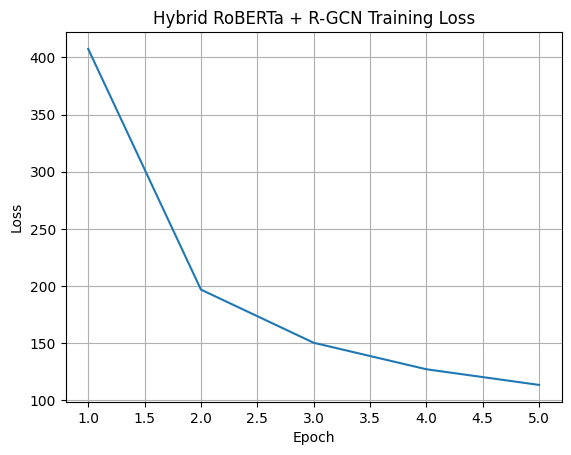

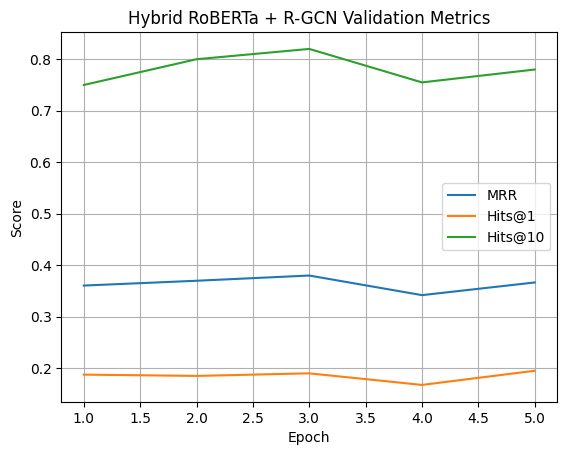

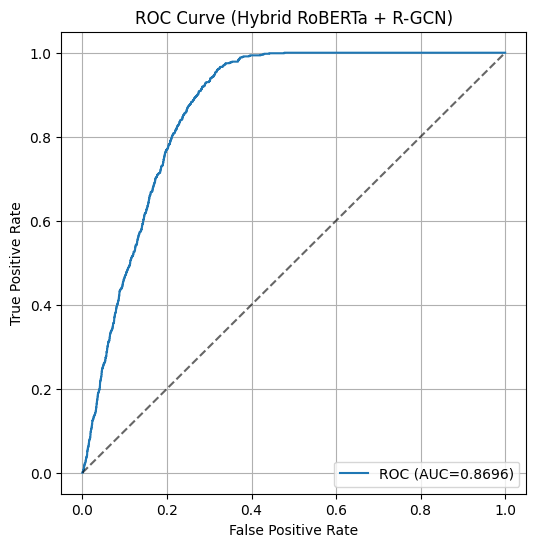

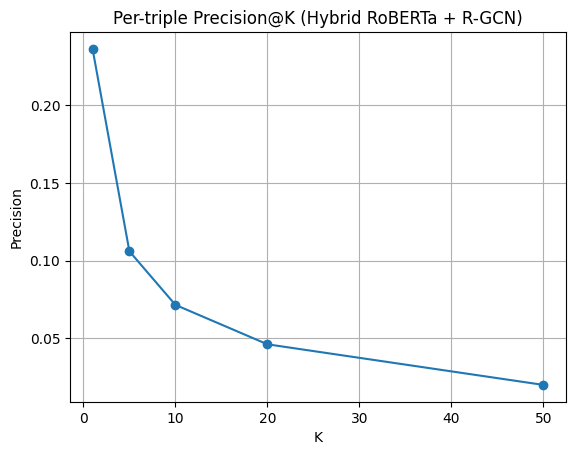

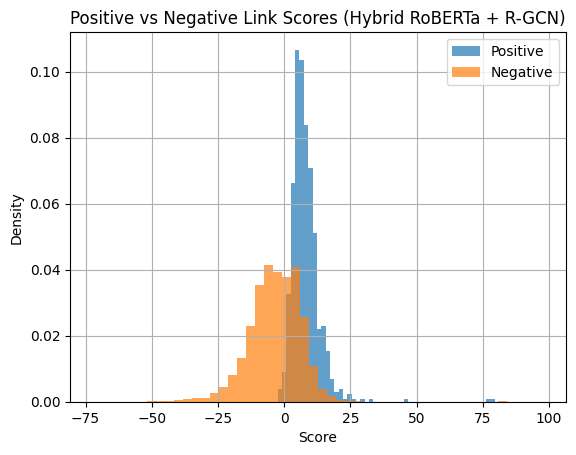

Saved all graphs to: /kaggle/working/hybrid_roberta_rgcn_out


In [11]:
# plots_hybrid.py
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

SAVE_DIR = "/kaggle/working/hybrid_roberta_rgcn_out"

def precision_at_k_per_triple(pos_scores, neg_scores, K):
    N, M = neg_scores.shape
    K = min(K, M + 1)
    precisions = []
    for i in range(N):
        scores = np.concatenate([[pos_scores[i]], neg_scores[i]])
        labels = np.concatenate([[1.0], np.zeros(M)])
        topk = np.argsort(scores)[::-1][:K]
        precisions.append(labels[topk].mean())
    return float(np.mean(precisions))

def main():
    history = np.load(os.path.join(SAVE_DIR, "training_history.npy"), allow_pickle=True).item()
    pos = np.load(os.path.join(SAVE_DIR, "pos_scores.npy")).reshape(-1)
    neg = np.load(os.path.join(SAVE_DIR, "neg_scores.npy"))
    neg_flat = neg.reshape(-1)

    # 1) Loss
    plt.figure()
    plt.plot(history["epoch"], history["loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hybrid RoBERTa + R-GCN Training Loss")
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, "training_loss.png"))
    plt.show()

    # 2) Metrics
    plt.figure()
    plt.plot(history["epoch"], history["mrr"], label="MRR")
    plt.plot(history["epoch"], history["h1"], label="Hits@1")
    plt.plot(history["epoch"], history["h10"], label="Hits@10")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Hybrid RoBERTa + R-GCN Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, "link_prediction_metrics.png"))
    plt.show()

    # 3) ROC
    y_true = np.concatenate([np.ones_like(pos), np.zeros_like(neg_flat)])
    y_score = np.concatenate([pos, neg_flat])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Hybrid RoBERTa + R-GCN)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, "roc_curve.png"))
    plt.show()

    # 4) Precision@K
    Ks = [1, 5, 10, 20, min(50, neg.shape[1])]
    precs = [precision_at_k_per_triple(pos, neg, k) for k in Ks]
    plt.figure()
    plt.plot(Ks, precs, marker="o")
    plt.xlabel("K")
    plt.ylabel("Precision")
    plt.title("Per-triple Precision@K (Hybrid RoBERTa + R-GCN)")
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, "precision_at_k.png"))
    plt.show()

    # 5) Score distribution
    plt.figure()
    plt.hist(pos, bins=50, alpha=0.7, label="Positive", density=True)
    plt.hist(neg_flat, bins=50, alpha=0.7, label="Negative", density=True)
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.title("Positive vs Negative Link Scores (Hybrid RoBERTa + R-GCN)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, "score_density.png"))
    plt.show()

    print("Saved all graphs to:", SAVE_DIR)

if __name__ == "__main__":
    main()


# SNOMED CT with RCGN Model 

In [2]:
import torch
import numpy as np
import os

IN_PATH  = "/kaggle/input/sn-rcgn/SN_graph_data.pt"
OUT_PATH = "/kaggle/working/SN_graph_data.pt"

data = torch.load(IN_PATH, map_location="cpu")
ei = data["edge_index"]     # [2, E]
et = data["edge_type"]      # [E]
num_nodes = int(data["num_nodes"])
num_rel   = int(data["num_relations"])

E = et.numel()
half = num_rel // 2

# ---- split ONLY on forward edges (canonical) ----
# canonical: r < half
forward_mask = (et < half)
f_idx = forward_mask.nonzero(as_tuple=False).view(-1)  # indices of forward edges

print("Total edges:", E)
print("Forward edges:", f_idx.numel(), "Inverse edges:", (E - f_idx.numel()))

# ---- shuffle forward edges and split ----
rng = np.random.default_rng(42)
perm = rng.permutation(f_idx.numel())

train_frac = 0.80
val_frac   = 0.10
test_frac  = 0.10

n_train = int(train_frac * f_idx.numel())
n_val   = int(val_frac   * f_idx.numel())
n_test  = f_idx.numel() - n_train - n_val

train_f = f_idx[perm[:n_train]]
val_f   = f_idx[perm[n_train:n_train+n_val]]
test_f  = f_idx[perm[n_train+n_val:]]

# ---- helper: find inverse edge index for each forward edge ----
# Since inverse edge is (t, r+half, h), we can build a lookup.
# Build a dictionary from (h,r,t) -> edge_index_id for inverse edges only
inv_mask = (et >= half)
inv_idx = inv_mask.nonzero(as_tuple=False).view(-1)

inv_lookup = {}
h_inv = ei[0, inv_idx].tolist()
t_inv = ei[1, inv_idx].tolist()
r_inv = et[inv_idx].tolist()

for idx_e, h, r, t in zip(inv_idx.tolist(), h_inv, r_inv, t_inv):
    inv_lookup[(h, r, t)] = idx_e

def get_inverse_indices(forward_edge_indices):
    h = ei[0, forward_edge_indices].tolist()
    t = ei[1, forward_edge_indices].tolist()
    r = et[forward_edge_indices].tolist()
    out = []
    missing = 0
    for hh, rr, tt in zip(h, r, t):
        rr_inv = rr + half
        key = (tt, rr_inv, hh)   # inverse triple (t, r+half, h)
        idx_inv = inv_lookup.get(key, None)
        if idx_inv is None:
            missing += 1
        else:
            out.append(idx_inv)
    if missing > 0:
        print("WARNING: missing inverse edges for", missing, "forward edges")
    return torch.tensor(out, dtype=torch.long)

train_inv = get_inverse_indices(train_f)
val_inv   = get_inverse_indices(val_f)
test_inv  = get_inverse_indices(test_f)

# ---- final split indices include both forward + inverse ----
train_idx = torch.cat([train_f, train_inv]).unique()
val_idx   = torch.cat([val_f,   val_inv]).unique()
test_idx  = torch.cat([test_f,  test_inv]).unique()

# ---- sanity: no overlap and inverse leakage should be ~0 now ----
train_set = set(train_idx.tolist())
val_set   = set(val_idx.tolist())
test_set  = set(test_idx.tolist())

print("Overlap train/val:", len(train_set & val_set))
print("Overlap train/test:", len(train_set & test_set))
print("Overlap val/test:", len(val_set & test_set))

# save
data2 = dict(data)
data2["train_idx"] = train_idx
data2["val_idx"]   = val_idx
data2["test_idx"]  = test_idx

torch.save(data2, OUT_PATH)
print("✅ Saved leakage-free graph:", OUT_PATH)


Total edges: 5693244
Forward edges: 2846622 Inverse edges: 2846622
Overlap train/val: 0
Overlap train/test: 0
Overlap val/test: 0
✅ Saved leakage-free graph: /kaggle/working/SN_graph_data.pt


In [6]:
%%writefile model_components.py

import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
#              GAP-1: Dynamic-capacity Embedder (SAFE)
# ============================================================
class DynamicEmbedder(nn.Module):
    def __init__(self, num_nodes, high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common):
        super().__init__()
        self.num_nodes = num_nodes
        self.emb_dim_common = emb_dim_common

        self.register_buffer("high_nodes", high_nodes.long())
        self.register_buffer("low_nodes", low_nodes.long())

        # ✅ FAST membership buffer
        is_high = torch.zeros(num_nodes, dtype=torch.bool)
        is_high[self.high_nodes.cpu()] = True
        self.register_buffer("is_high", is_high)

        self.id_map_high = {int(n): i for i, n in enumerate(self.high_nodes.tolist())}
        self.id_map_low  = {int(n): i for i, n in enumerate(self.low_nodes.tolist())}

        self.emb_high = nn.Embedding(len(self.high_nodes), emb_dim_high)
        self.emb_low  = nn.Embedding(len(self.low_nodes),  emb_dim_low)

        self.proj_high = nn.Linear(emb_dim_high, emb_dim_common)
        self.proj_low  = nn.Linear(emb_dim_low,  emb_dim_common)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.emb_high.weight)
        nn.init.xavier_uniform_(self.emb_low.weight)
        nn.init.xavier_uniform_(self.proj_high.weight)
        nn.init.xavier_uniform_(self.proj_low.weight)
        nn.init.zeros_(self.proj_high.bias)
        nn.init.zeros_(self.proj_low.bias)

    def forward(self, node_ids):
        DEVICE = node_ids.device
        node_ids_cpu = node_ids.cpu()

        out = torch.zeros(
            node_ids.size(0),
            self.emb_dim_common,
            device=DEVICE,
            dtype=torch.float32
        )

        # ✅ FAST + device-safe mask
        high_mask = self.is_high[node_ids_cpu].cpu()
        low_mask = ~high_mask

        high_mask_gpu = high_mask.to(DEVICE)
        low_mask_gpu  = low_mask.to(DEVICE)

        if high_mask.any():
            high_nodes = node_ids_cpu[high_mask]
            high_idx = torch.tensor([self.id_map_high[int(i)] for i in high_nodes], device=DEVICE)
            high_emb = self.proj_high(self.emb_high(high_idx))
            out[high_mask_gpu] = high_emb.to(out.dtype)

        if low_mask.any():
            low_nodes = node_ids_cpu[low_mask]
            low_idx = torch.tensor([self.id_map_low.get(int(i), 0) for i in low_nodes], device=DEVICE)
            low_emb = self.proj_low(self.emb_low(low_idx))
            out[low_mask_gpu] = low_emb.to(out.dtype)

        return out



# ============================================================
#                    SAFE R-GCN Layer (OOM-FREE)
# ============================================================
class RGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_relations):
        super().__init__()
        self.num_relations = num_relations
        self.W_r = nn.Parameter(torch.empty(num_relations, in_dim, out_dim))
        self.W_0 = nn.Linear(in_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W_r)
        nn.init.xavier_uniform_(self.W_0.weight)
        nn.init.zeros_(self.W_0.bias)

    # ✅ Memory-safe relation-wise message passing
    def forward(self, x, edge_index, edge_type, num_nodes_local):
        DEVICE = x.device
        src = edge_index[0]
        dst = edge_index[1]

        out = torch.zeros(
            num_nodes_local,
            self.W_0.out_features,
            device=DEVICE,
            dtype=x.dtype   # ✅ CRITICAL AMP FIX
        )


        deg = torch.zeros(num_nodes_local, device=DEVICE, dtype=x.dtype)
        deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

        for r in range(self.num_relations):
            mask = (edge_type == r)
            if mask.sum() == 0:
                continue

            s = src[mask]
            d = dst[mask]

            msg = x[s] @ self.W_r[r]
            msg = msg / deg[d].clamp_min(1).unsqueeze(1)
            out.index_add_(0, d, msg)

        return out + self.W_0(x)


# ============================================================
#                    Full R-GCN (GAP-1 + GAP-2)
# ============================================================
class PureRGCN(nn.Module):
    def __init__(self, num_nodes, num_relations,
                 high_nodes, low_nodes,
                 emb_dim_high, emb_dim_low, emb_dim_common,
                 hidden_dim, num_layers, dropout):
        super().__init__()

        self.embedder = DynamicEmbedder(
            num_nodes, high_nodes, low_nodes,
            emb_dim_high, emb_dim_low, emb_dim_common
        )

        self.layers = nn.ModuleList()
        in_dim = emb_dim_common

        for i in range(num_layers):
            out = hidden_dim if i < num_layers - 1 else emb_dim_common
            self.layers.append(RGCNLayer(in_dim, out, num_relations))
            in_dim = out

        self.dropout = nn.Dropout(dropout)
        self.rel_embed = nn.Embedding(num_relations, emb_dim_common)

    # ✅ ✅ ✅ THIS IS THE ONLY CORRECT FORWARD
    def forward(self, local_nodes, edge_index_local, edge_type_local):
        x = self.embedder(local_nodes)

        for i, layer in enumerate(self.layers):
            x = layer(
                x,
                edge_index_local,
                edge_type_local,
                local_nodes.numel()   # ✅ required argument
            )

            if i < len(self.layers) - 1:
                x = F.relu(x)
                x = self.dropout(x)

        return x

    def score(self, h_global, r, t_global, local_nodes, local_emb):
        DEVICE = local_nodes.device
        lut = {int(g): i for i, g in enumerate(local_nodes.tolist())}

        h = local_emb[
            torch.tensor([lut[int(i)] for i in h_global.tolist()], device=DEVICE)
        ]
        t = local_emb[
            torch.tensor([lut[int(i)] for i in t_global.tolist()], device=DEVICE)
        ]

        rvec = self.rel_embed(r)
        return torch.sum(h * rvec * t, dim=-1)


# ============================================================
#                      Degree Split (GAP-1)
# ============================================================
def compute_degree(num_nodes, edge_index):
    deg = torch.zeros(num_nodes, dtype=torch.long)
    deg.index_add_(0, edge_index[0].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    deg.index_add_(0, edge_index[1].cpu(), torch.ones(edge_index.size(1), dtype=torch.long))
    return deg

def degree_split(num_nodes, edge_index, pct):
    deg = compute_degree(num_nodes, edge_index)
    thresh = int(np.percentile(deg.numpy(), pct * 100))
    high = (deg >= thresh).nonzero(as_tuple=False).view(-1)
    low  = (deg <  thresh).nonzero(as_tuple=False).view(-1)
    return high, low


# ============================================================
#                Adjacency for Neighbor Sampling (GAP-2)
# ============================================================
def build_adj(num_nodes, edge_index, edge_type, num_relations):
    edge_index = edge_index.cpu()
    edge_type  = edge_type.cpu()

    out_neighbors = [defaultdict(list) for _ in range(num_relations)]

    for s, d, r in zip(
        edge_index[0].tolist(),
        edge_index[1].tolist(),
        edge_type.tolist()
    ):
        out_neighbors[r][s].append(d)

    return out_neighbors


# ============================================================
#                 Pure Python Neighbor Sampler (SAFE)
# ============================================================
def sample_subgraph(seeds, num_layers, num_neighbors,
                    node_adj, num_relations, max_edges):

    # Convert seeds to Python ints
    frontier = set(int(s) for s in seeds.tolist())
    nodes = set(frontier)

    # -----------------------
    # LAYER-WISE EXPANSION
    # -----------------------
    for _ in range(num_layers):

        new_frontier = set()

        for u in list(frontier):

            # If node has no neighbors
            if u not in node_adj:
                continue

            nbrs = node_adj[u]  # list of (relation, dst)

            # Sample neighbors
            if len(nbrs) <= num_neighbors:
                chosen = nbrs
            else:
                chosen = random.sample(nbrs, num_neighbors)

            for r, v in chosen:
                if v not in nodes:
                    nodes.add(v)
                    new_frontier.add(v)

        frontier = new_frontier

        # Hard cap to avoid huge subgraphs
        if len(nodes) * num_neighbors * num_layers > 2 * max_edges:
            break

    # -----------------------
    # BUILD LOCAL GRAPH
    # -----------------------
    local_nodes = sorted(nodes)
    lut = {g: i for i, g in enumerate(local_nodes)}

    ls, ld, lr = [], [], []
    edge_count = 0

    for u in local_nodes:

        if u not in node_adj:
            continue

        u_local = lut[u]

        for r, v in node_adj[u]:
            if v in nodes:
                ls.append(u_local)
                ld.append(lut[v])
                lr.append(r)
                edge_count += 1

                if edge_count >= max_edges:
                    break

    DEVICE = seeds.device

    edge_index_local = torch.tensor([ls, ld], dtype=torch.long, device=DEVICE)
    edge_type_local  = torch.tensor(lr, dtype=torch.long, device=DEVICE)
    local_nodes      = torch.tensor(local_nodes, dtype=torch.long, device=DEVICE)

    return local_nodes, edge_index_local, edge_type_local


# ============================================================
#         Negative Sampling (training utility)
# ============================================================
def sample_pos_neg(edge_index, edge_type, idx, num_nodes, negative_ratio):
    pos_edges = edge_index[:, idx]
    pos_r = edge_type[idx]
    B = pos_edges.size(1)

    neg_t = torch.randint(0, num_nodes, (B * negative_ratio,), device=edge_index.device)
    neg_h = pos_edges[0].repeat(negative_ratio)
    neg_r = pos_r.repeat(negative_ratio)

    return pos_edges[0], pos_r, pos_edges[1], neg_h, neg_r, neg_t


Overwriting model_components.py


In [7]:
%%writefile train_rgcn_snomed_gap1_gap2.py
import os
import time
import numpy as np
import torch
from torch.amp import autocast, GradScaler

from model_components import (
    PureRGCN,
    degree_split,
    sample_pos_neg,
    sample_subgraph,
)

# -------------------------------
# PATHS (SNOMED)
# -------------------------------
GRAPH_DATA = "/kaggle/working/SN_graph_data.pt"
NODE_ADJ_PATH = "/kaggle/input/sn-rcgn/SN_node_adj.pt"

SAVE_DIR = "/kaggle/working/sn_with_rcgn"
os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# YOUR EMBEDDING HYPERPARAMS
# -------------------------------
EMB_DIM_HIGH = 512
EMB_DIM_LOW  = 128
EMB_DIM_COMMON = 256

HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2

NUM_NEIGHBORS = 5
HIGH_DEG_PCT = 0.80
MAX_EDGES = 300_000      # safe start; increase slowly if needed

LR = 1e-3
EPOCHS = 5
BATCH_SIZE = 2048
NEGATIVE_RATIO = 1

# Eval
VAL_STEP = 512
K_NEG = 50
NEG_SAVE_K = 50


@torch.no_grad()
def eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel):
    model.eval()

    all_pos_scores = []
    all_neg_scores = []

    rr = hits1 = hits10 = 0
    total = 0

    for start in range(0, val_idx.numel(), VAL_STEP):
        sl = val_idx[start:start+VAL_STEP]

        pos_e = edge_index[:, sl]
        pos_r = edge_type[sl]

        seeds = torch.cat([pos_e[0], pos_e[1]]).unique()

        local_nodes, eidx, etype = sample_subgraph(
            seeds, NUM_LAYERS, NUM_NEIGHBORS,
            node_adj, num_rel, MAX_EDGES
        )

        if eidx.numel() == 0:
            local_nodes = seeds
            eidx  = torch.empty(2, 0, dtype=torch.long, device=DEVICE)
            etype = torch.empty(0, dtype=torch.long, device=DEVICE)

        with autocast("cuda"):
            local_emb = model(local_nodes, eidx, etype)
            true_scores = model.score(pos_e[0], pos_r, pos_e[1], local_nodes, local_emb)

            # negatives from LOCAL nodes (realistic; no “too perfect” bug)
            K = min(K_NEG, local_nodes.numel())
            neg_idx = torch.randint(0, local_nodes.numel(), (true_scores.size(0), K), device=DEVICE)
            neg_tails = local_nodes[neg_idx]

            neg_scores = []
            for i in range(true_scores.size(0)):
                hs = pos_e[0][i].repeat(K)
                rs = pos_r[i].repeat(K)
                ts = neg_tails[i]
                neg_scores.append(model.score(hs, rs, ts, local_nodes, local_emb).unsqueeze(0))

            neg_scores = torch.cat(neg_scores, dim=0)

        ranks = 1 + (neg_scores > true_scores.unsqueeze(1)).sum(1)

        rr += (1.0 / ranks.float()).sum().item()
        hits1 += (ranks <= 1).sum().item()
        hits10 += (ranks <= 10).sum().item()
        total += ranks.numel()

        all_pos_scores.append(true_scores.detach().float().cpu())
        kk = min(NEG_SAVE_K, neg_scores.size(1))
        all_neg_scores.append(neg_scores[:, :kk].detach().float().cpu())

    pos_arr = torch.cat(all_pos_scores, dim=0).numpy()
    neg_arr = torch.cat(all_neg_scores, dim=0).numpy()

    np.save(f"{SAVE_DIR}/pos_scores.npy", pos_arr)
    np.save(f"{SAVE_DIR}/neg_scores.npy", neg_arr)

    return {"MRR": rr/total, "H@1": hits1/total, "H@10": hits10/total}


def main():
    print("Loading graph:", GRAPH_DATA)
    data = torch.load(GRAPH_DATA, map_location="cpu")

    num_nodes = int(data["num_nodes"])
    num_rel   = int(data["num_relations"])

    edge_index = data["edge_index"].to(DEVICE)
    edge_type  = data["edge_type"].to(DEVICE)

    train_idx = data["train_idx"].to(DEVICE)
    val_idx   = data["val_idx"].to(DEVICE)

    print(f"Graph loaded: nodes={num_nodes:,} rels={num_rel:,} edges={edge_type.numel():,}")

    print("⚡ Loading node-centric adjacency...")
    node_adj = torch.load(NODE_ADJ_PATH, map_location="cpu")
    if not isinstance(node_adj, dict):
        node_adj = dict(node_adj)
    print("node_adj loaded")

    # GAP-1 degree split on SNOMED graph
    high, low = degree_split(num_nodes, edge_index, HIGH_DEG_PCT)
    print(f"High-degree: {high.numel()} | Low-degree: {low.numel()}")

    model = PureRGCN(
        num_nodes, num_rel,
        high.to(DEVICE), low.to(DEVICE),
        EMB_DIM_HIGH, EMB_DIM_LOW, EMB_DIM_COMMON,
        HIDDEN_DIM, NUM_LAYERS, DROPOUT
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = GradScaler("cuda")

    history = {"epoch": [], "loss": [], "mrr": [], "h1": [], "h10": []}
    best_mrr = -1.0
    best_path = f"{SAVE_DIR}/pure_rgcn_snomed_best.pt"

    for ep in range(1, EPOCHS + 1):
        model.train()
        t0 = time.time()

        total_loss = 0.0
        perm = torch.randperm(train_idx.numel(), device=DEVICE)

        for start in range(0, perm.numel(), BATCH_SIZE):
            batch = train_idx[perm[start:start+BATCH_SIZE]]

            if ep == 1 and start == 0:
                print("🚀 First batch started...")

            pos_h, pos_r, pos_t, neg_h, neg_r, neg_t = sample_pos_neg(
                edge_index, edge_type, batch, num_nodes, NEGATIVE_RATIO
            )

            seeds = torch.cat([pos_h, pos_t, neg_h, neg_t]).unique()

            local_nodes, eidx, etype = sample_subgraph(
                seeds, NUM_LAYERS, NUM_NEIGHBORS,
                node_adj, num_rel, MAX_EDGES
            )

            if ep == 1 and start == 0:
                print(f"First subgraph ready: nodes={local_nodes.numel()} edges={eidx.size(1)}")

            if eidx.numel() == 0:
                local_nodes = seeds
                eidx  = torch.empty(2, 0, dtype=torch.long, device=DEVICE)
                etype = torch.empty(0, dtype=torch.long, device=DEVICE)

            with autocast("cuda"):
                local_emb = model(local_nodes, eidx, etype)
                pos_score = model.score(pos_h, pos_r, pos_t, local_nodes, local_emb)
                neg_score = model.score(neg_h, neg_r, neg_t, local_nodes, local_emb)

                loss = torch.nn.functional.margin_ranking_loss(
                    pos_score, neg_score,
                    torch.ones_like(pos_score), margin=1.0
                )

            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            if ep == 1 and start == 0:
                print("First optimizer step completed.")

            total_loss += loss.item()

        dt = (time.time() - t0) / 60.0
        print(f"\nEpoch {ep:02d} | Loss={total_loss:.4f}")

        val_metrics = eval_batched(model, edge_index, edge_type, val_idx, node_adj, num_rel)
        print(f"VAL → MRR={val_metrics['MRR']:.4f} | H@1={val_metrics['H@1']:.4f} | H@10={val_metrics['H@10']:.4f}")

        history["epoch"].append(ep)
        history["loss"].append(total_loss)
        history["mrr"].append(val_metrics["MRR"])
        history["h1"].append(val_metrics["H@1"])
        history["h10"].append(val_metrics["H@10"])

        ckpt_path = f"{SAVE_DIR}/epoch_{ep:02d}.pt"
        torch.save(model.state_dict(), ckpt_path)
        print("Saved checkpoint:", ckpt_path)

        if val_metrics["MRR"] > best_mrr:
            best_mrr = val_metrics["MRR"]
            torch.save(model.state_dict(), best_path)
            print("✅ Saved best checkpoint:", best_path)

        np.save(f"{SAVE_DIR}/training_history.npy", history)

    final_path = f"{SAVE_DIR}/pure_rgcn_snomed_final.pt"
    torch.save(model.state_dict(), final_path)
    print("Saved FINAL model:", final_path)

    np.save(f"{SAVE_DIR}/training_history.npy", history)
    print("Saved training history.")


if __name__ == "__main__":
    main()


Overwriting train_rgcn_snomed_gap1_gap2.py


In [8]:
!python train_rgcn_snomed_gap1_gap2.py

Loading graph: /kaggle/working/SN_graph_data.pt
Graph loaded: nodes=481,066 rels=266 edges=5,693,244
⚡ Loading node-centric adjacency...
node_adj loaded
High-degree: 100220 | Low-degree: 380846
🚀 First batch started...
First subgraph ready: nodes=60324 edges=341662
First optimizer step completed.

Epoch 01 | Loss=156.3651
VAL → MRR=0.6969 | H@1=0.5465 | H@10=0.9712
Saved checkpoint: /kaggle/working/sn_with_rcgn/epoch_01.pt
✅ Saved best checkpoint: /kaggle/working/sn_with_rcgn/pure_rgcn_snomed_best.pt

Epoch 02 | Loss=72.2802
VAL → MRR=0.7259 | H@1=0.5833 | H@10=0.9773
Saved checkpoint: /kaggle/working/sn_with_rcgn/epoch_02.pt
✅ Saved best checkpoint: /kaggle/working/sn_with_rcgn/pure_rgcn_snomed_best.pt

Epoch 03 | Loss=57.8262
VAL → MRR=0.7476 | H@1=0.6128 | H@10=0.9789
Saved checkpoint: /kaggle/working/sn_with_rcgn/epoch_03.pt
✅ Saved best checkpoint: /kaggle/working/sn_with_rcgn/pure_rgcn_snomed_best.pt

Epoch 04 | Loss=51.2544
VAL → MRR=0.7561 | H@1=0.6234 | H@10=0.9817
Saved check

Loaded from YOUR code outputs:
 - training_history: {'epoch': 5, 'loss': 5, 'mrr': 5, 'h1': 5, 'h10': 5}
 - pos_scores: (569324,)
 - neg_scores: (569324, 50) (this equals NEG_SAVE_K in your training code)


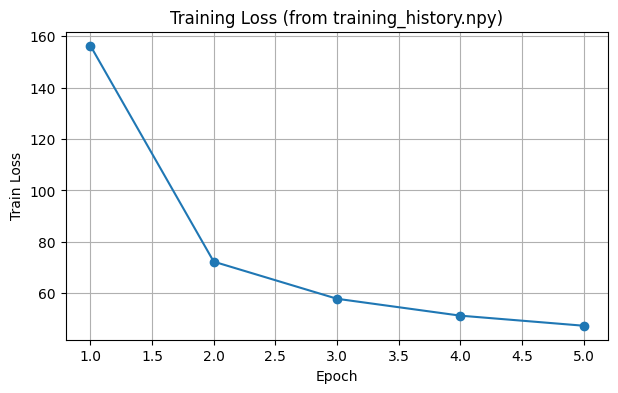

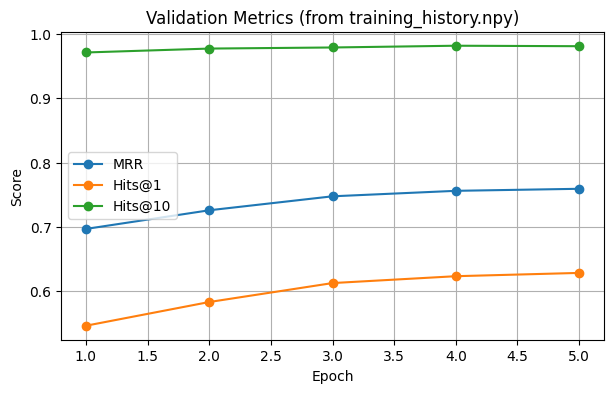

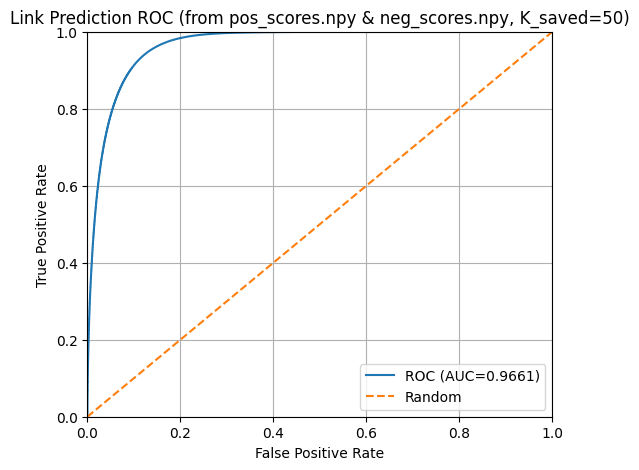

ROC AUC (from YOUR saved scores): 0.9661


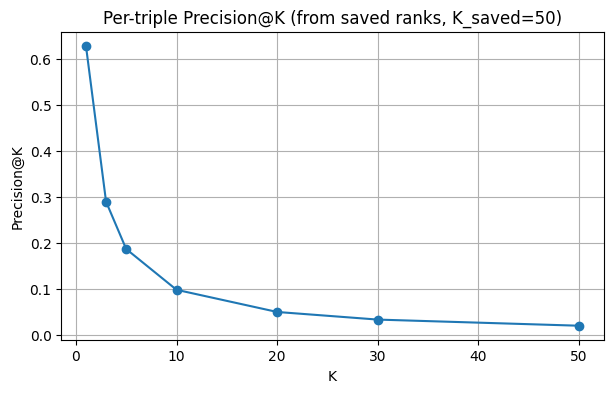

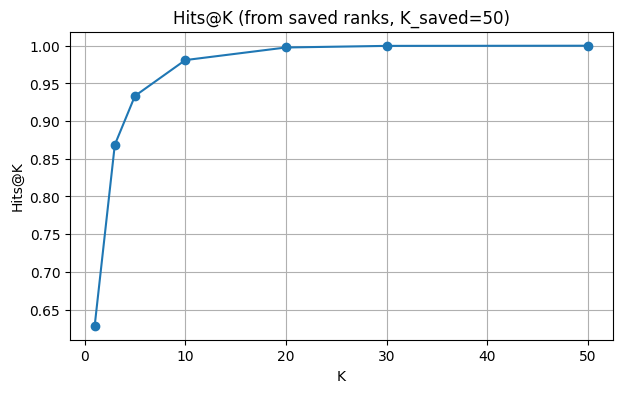

K= 1 | Hits@K=0.6285 | Precision@K=0.6285
K= 3 | Hits@K=0.8686 | Precision@K=0.2895
K= 5 | Hits@K=0.9334 | Precision@K=0.1867
K=10 | Hits@K=0.9809 | Precision@K=0.0981
K=20 | Hits@K=0.9977 | Precision@K=0.0499
K=30 | Hits@K=0.9998 | Precision@K=0.0333
K=50 | Hits@K=1.0000 | Precision@K=0.0200
Sampled MRR computed from saved ranks: 0.7593


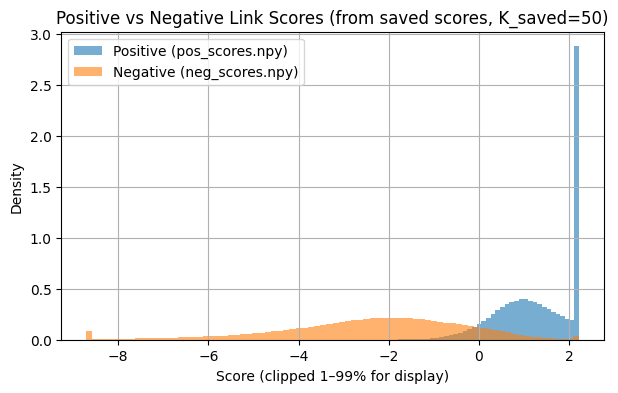

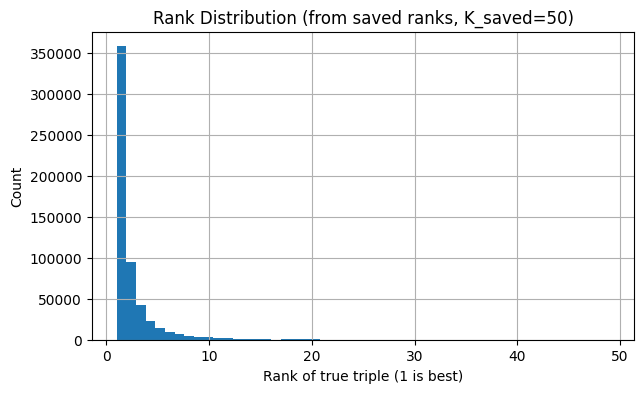

In [9]:
# ============================================================
# PLOTS THAT MATCH YOUR CODE OUTPUTS (NO EXTRA SAMPLING)
# Uses exactly:
#   /kaggle/working/sn_with_rcgn/training_history.npy
#   /kaggle/working/sn_with_rcgn/pos_scores.npy
#   /kaggle/working/sn_with_rcgn/neg_scores.npy
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt

SAVE_DIR = "/kaggle/working/sn_with_rcgn"

HIST_PATH = os.path.join(SAVE_DIR, "training_history.npy")
POS_PATH  = os.path.join(SAVE_DIR, "pos_scores.npy")
NEG_PATH  = os.path.join(SAVE_DIR, "neg_scores.npy")

# ----------------------------
# 0) Load files produced by YOUR code
# ----------------------------
history = np.load(HIST_PATH, allow_pickle=True).item()
pos = np.load(POS_PATH).astype(np.float64)          # (N,)
neg = np.load(NEG_PATH).astype(np.float64)          # (N, K_saved)

epochs = np.array(history["epoch"], dtype=np.int64)
loss   = np.array(history["loss"], dtype=np.float64)
mrr    = np.array(history["mrr"], dtype=np.float64)
h1     = np.array(history["h1"], dtype=np.float64)
h10    = np.array(history["h10"], dtype=np.float64)

N = pos.shape[0]
K_saved = neg.shape[1]

print("Loaded from YOUR code outputs:")
print(" - training_history:", {k: len(v) for k, v in history.items()})
print(" - pos_scores:", pos.shape)
print(" - neg_scores:", neg.shape, "(this equals NEG_SAVE_K in your training code)")

# ----------------------------
# 1) Training Loss (YOUR code)
# ----------------------------
plt.figure(figsize=(7,4))
plt.plot(epochs, loss, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss (from training_history.npy)")
plt.grid(True)
plt.show()

# ----------------------------
# 2) LINK PREDICTION METRICS (YOUR code)
# ----------------------------
plt.figure(figsize=(7,4))
plt.plot(epochs, mrr, marker="o", label="MRR")
plt.plot(epochs, h1,  marker="o", label="Hits@1")
plt.plot(epochs, h10, marker="o", label="Hits@10")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics (from training_history.npy)")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# Everything below uses ONLY pos_scores.npy and neg_scores.npy
# (exactly what eval_batched saved)
# ============================================================

# ranks computed exactly like your eval_batched()
ranks = 1 + (neg > pos[:, None]).sum(axis=1)  # (N,)

# ----------------------------
# 3) ROC Curve (from YOUR saved scores)
# IMPORTANT:
#   Your saved file is per-triple: 1 positive + K_saved negatives.
#   ROC treats each score as a classifier score:
#     positives = pos_scores (N)
#     negatives = neg_scores (N*K_saved)
# No balancing, no subsampling.
# ----------------------------
y_true = np.concatenate([np.ones(N), np.zeros(N * K_saved)])
y_score = np.concatenate([pos, neg.reshape(-1)])

# manual ROC
order = np.argsort(-y_score)
y_true_sorted = y_true[order]

tps = np.cumsum(y_true_sorted == 1)
fps = np.cumsum(y_true_sorted == 0)

TPR = tps / max(tps[-1], 1)
FPR = fps / max(fps[-1], 1)

auc = np.trapz(TPR, FPR)

plt.figure(figsize=(6,5))
plt.plot(FPR, TPR, label=f"ROC (AUC={auc:.4f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Link Prediction ROC (from pos_scores.npy & neg_scores.npy, K_saved={K_saved})")
plt.grid(True)
plt.legend()
plt.show()

print(f"ROC AUC (from YOUR saved scores): {auc:.4f}")

# ----------------------------
# 4) Per-triple Precision@K (from YOUR ranks)
# In your setting (one true per query):
#   Precision@K = 1/K if rank<=K else 0
# ----------------------------
Ks = [1, 3, 5, 10, 20, 30, 50]
Ks = [k for k in Ks if k <= K_saved + 1]

prec_k = [np.mean((ranks <= k).astype(np.float64) * (1.0 / k)) for k in Ks]

plt.figure(figsize=(7,4))
plt.plot(Ks, prec_k, marker="o")
plt.xlabel("K")
plt.ylabel("Precision@K")
plt.title(f"Per-triple Precision@K (from saved ranks, K_saved={K_saved})")
plt.grid(True)
plt.show()

# ----------------------------
# 5) Hits@K (from YOUR ranks)
# ----------------------------
hits_k = [np.mean(ranks <= k) for k in Ks]

plt.figure(figsize=(7,4))
plt.plot(Ks, hits_k, marker="o")
plt.xlabel("K")
plt.ylabel("Hits@K")
plt.title(f"Hits@K (from saved ranks, K_saved={K_saved})")
plt.grid(True)
plt.show()

for k, hk, pk in zip(Ks, hits_k, prec_k):
    print(f"K={k:2d} | Hits@K={hk:.4f} | Precision@K={pk:.4f}")

print(f"Sampled MRR computed from saved ranks: {np.mean(1.0 / ranks):.4f}")

# ----------------------------
# 6) Positive vs Negative Link Scores (Density)
# NO sampling: use ALL negatives in neg_scores.npy
# Use density=True so scales are comparable even though negatives are more.
# ----------------------------
# Optional clip for readability (does NOT change data, just display)
all_scores = np.concatenate([pos, neg.reshape(-1)])
lo, hi = np.percentile(all_scores, 1), np.percentile(all_scores, 99)
pos_c = np.clip(pos, lo, hi)
neg_c = np.clip(neg.reshape(-1), lo, hi)

plt.figure(figsize=(7,4))
plt.hist(pos_c, bins=80, density=True, alpha=0.6, label="Positive (pos_scores.npy)")
plt.hist(neg_c, bins=80, density=True, alpha=0.6, label="Negative (neg_scores.npy)")
plt.xlabel("Score (clipped 1–99% for display)")
plt.ylabel("Density")
plt.title(f"Positive vs Negative Link Scores (from saved scores, K_saved={K_saved})")
plt.grid(True)
plt.legend()
plt.show()

# (optional) rank distribution
plt.figure(figsize=(7,4))
plt.hist(ranks, bins=min(60, K_saved+1))
plt.xlabel("Rank of true triple (1 is best)")
plt.ylabel("Count")
plt.title(f"Rank Distribution (from saved ranks, K_saved={K_saved})")
plt.grid(True)
plt.show()


In [1]:
import torch

GRAPH_DATA = "/kaggle/input/sn-rcgn/SN_graph_data.pt"
data = torch.load(GRAPH_DATA, map_location="cpu")

ei = data["edge_index"]
et = data["edge_type"]
tr = data["train_idx"]
va = data["val_idx"]

def triples(idxs):
    h = ei[0, idxs].tolist()
    t = ei[1, idxs].tolist()
    r = et[idxs].tolist()
    return set(zip(h, r, t))

train_set = triples(tr)
val_set   = triples(va)

print("Train triples:", len(train_set))
print("Val triples:", len(val_set))
print("Exact overlap (train ∩ val):", len(train_set & val_set))

# inverse leakage check (approx)
# If your inverse is created as r_inv = r + (num_rel/2),
# then this checks overlap for that common scheme.
num_rel = int(data["num_relations"])
half = num_rel // 2

inv_hits = 0
sample = list(val_set)[:200000]  # limit for speed
train_lookup = train_set

for (h, r, t) in sample:
    r_inv = r + half if r < half else r - half
    if (t, r_inv, h) in train_lookup:
        inv_hits += 1

print(f"Inverse leakage rate on sample: {inv_hits/len(sample):.4f}")


Train triples: 4554595
Val triples: 569324
Exact overlap (train ∩ val): 0
Inverse leakage rate on sample: 0.7994


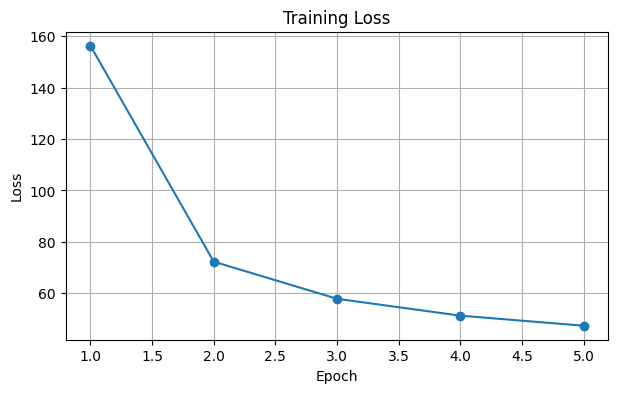

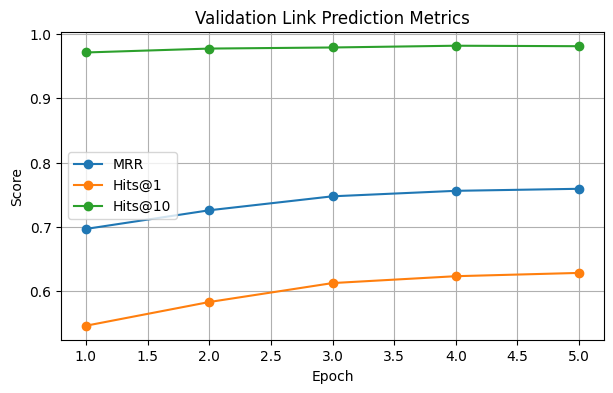

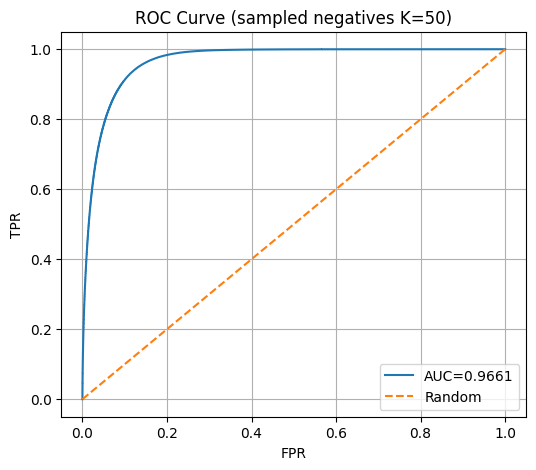

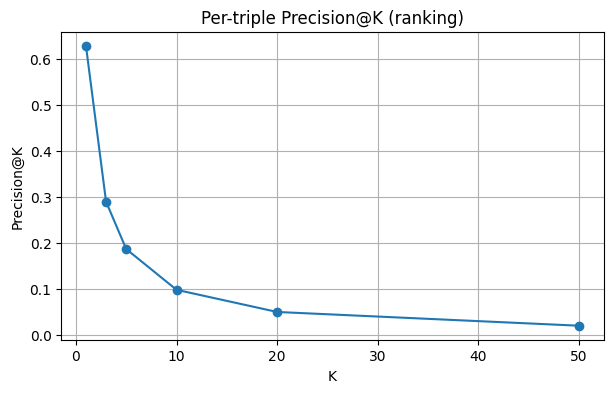

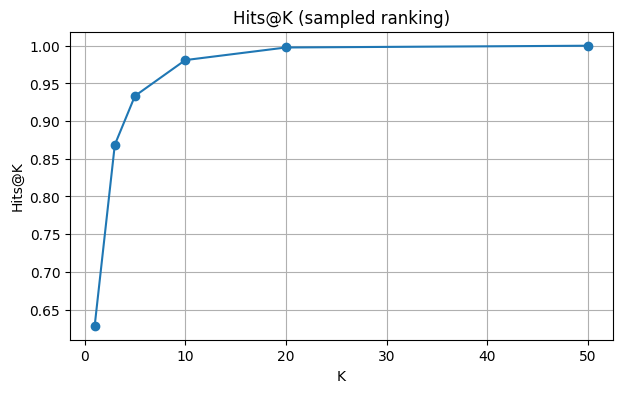

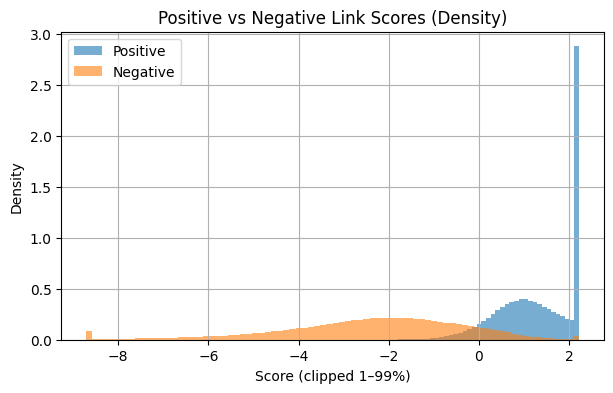

In [10]:
import os, numpy as np
import matplotlib.pyplot as plt

SAVE_DIR = "/kaggle/working/sn_with_rcgn"
history = np.load(f"{SAVE_DIR}/training_history.npy", allow_pickle=True).item()
pos = np.load(f"{SAVE_DIR}/pos_scores.npy").astype(np.float64)          # (N,)
neg = np.load(f"{SAVE_DIR}/neg_scores.npy").astype(np.float64)          # (N,K)

epochs = np.array(history["epoch"])
loss   = np.array(history["loss"])
mrr    = np.array(history["mrr"])
h1     = np.array(history["h1"])
h10    = np.array(history["h10"])

N = pos.shape[0]
K = neg.shape[1]
ranks = 1 + (neg > pos[:, None]).sum(axis=1)

# 1) Training Loss
plt.figure(figsize=(7,4))
plt.plot(epochs, loss, marker="o")
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 2) Link Prediction Metrics (MRR/H@1/H@10)
plt.figure(figsize=(7,4))
plt.plot(epochs, mrr, marker="o", label="MRR")
plt.plot(epochs, h1, marker="o", label="Hits@1")
plt.plot(epochs, h10, marker="o", label="Hits@10")
plt.title("Validation Link Prediction Metrics")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

# 3) ROC Curve from saved scores (1 pos vs K neg per triple)
y_true  = np.concatenate([np.ones(N), np.zeros(N*K)])
y_score = np.concatenate([pos, neg.reshape(-1)])

order = np.argsort(-y_score)
y_true = y_true[order]

tps = np.cumsum(y_true == 1)
fps = np.cumsum(y_true == 0)

TPR = tps / max(tps[-1], 1)
FPR = fps / max(fps[-1], 1)
auc = np.trapz(TPR, FPR)

plt.figure(figsize=(6,5))
plt.plot(FPR, TPR, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],"--", label="Random")
plt.title(f"ROC Curve (sampled negatives K={K})")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.grid(True)
plt.legend()
plt.show()

# 4) Precision@K (ranking definition; true=1)
Ks = [1,3,5,10,20,50,100,200,500]
Ks = [k for k in Ks if k <= K+1]

precision_k = [np.mean((ranks <= k) * (1.0/k)) for k in Ks]
plt.figure(figsize=(7,4))
plt.plot(Ks, precision_k, marker="o")
plt.title("Per-triple Precision@K (ranking)")
plt.xlabel("K"); plt.ylabel("Precision@K")
plt.grid(True)
plt.show()

# 5) Hits@K
hits_k = [np.mean(ranks <= k) for k in Ks]
plt.figure(figsize=(7,4))
plt.plot(Ks, hits_k, marker="o")
plt.title("Hits@K (sampled ranking)")
plt.xlabel("K"); plt.ylabel("Hits@K")
plt.grid(True)
plt.show()

# 6) Positive vs Negative score density (display clipped)
all_scores = np.concatenate([pos, neg.reshape(-1)])
lo, hi = np.percentile(all_scores, 1), np.percentile(all_scores, 99)
pos_c = np.clip(pos, lo, hi)
neg_c = np.clip(neg.reshape(-1), lo, hi)

plt.figure(figsize=(7,4))
plt.hist(pos_c, bins=80, density=True, alpha=0.6, label="Positive")
plt.hist(neg_c, bins=80, density=True, alpha=0.6, label="Negative")
plt.title("Positive vs Negative Link Scores (Density)")
plt.xlabel("Score (clipped 1–99%)"); plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()
